### Cleaning Data
Credits:
https://www.geeksforgeeks.org/how-to-perform-a-one-way-anova-in-python/#
https://towardsdatascience.com/anova-t-test-and-other-statistical-tests-with-python-e7a36a2fdc0c
https://datagy.io/t-test-python/
https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/#
https://www.statology.org/seaborn-normal-distribution/
https://builtin.com/data-science/shapiro-wilk-test
https://www.graphpad.com/support/faq/testing-data-for-normal-distrbution/
https://statsidea.com/en/python/welchs-anova-in-python-step-by-step/
https://www.datacamp.com/tutorial/seaborn-heatmaps

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.pipeline import make_pipeline 
import seaborn as sns
import statsmodels.api as sm 
import pingouin as pg 
import math

In [196]:
penguin_df = pd.read_csv('penguins.csv')
penguin_df.drop(['island','sex','year'], inplace=True, axis=1)
penguin_df.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,NaN,NaN,NaN,NaN
4,Adelie,36.7,19.3,193.0,3450.0


In [197]:
penguin_df.isnull().sum()

species              0
bill_length_mm       2
bill_depth_mm        2
flipper_length_mm    2
body_mass_g          2
dtype: int64

In [198]:
penguin_df.dropna(how='any', axis=0, inplace=True)
penguin_df.isnull().sum()

species              0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
dtype: int64

In [207]:
numerical_cols =  ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_cols = ['species']

### Bell Curve Graphs
By these graphs we can tell that they are not perfectly normally distributed, but they are practically normally distributed. For the following data, all sample sizes are greater than 30. Since we are using ANOVA and T-test, the graph does not need to be fully normally distributed. This may cause some Type 1 errors, so we will need to ensure that it has homogeneity of variances and sample size is over 30.

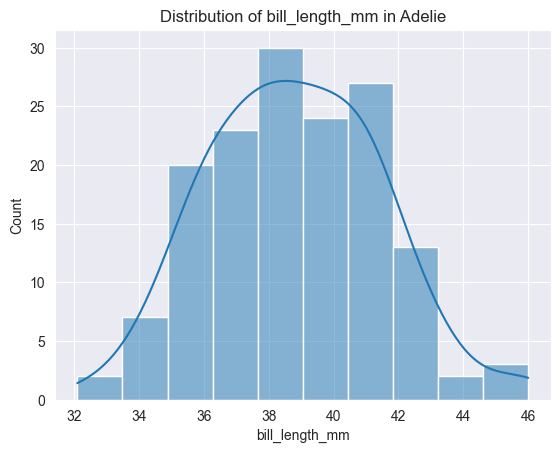

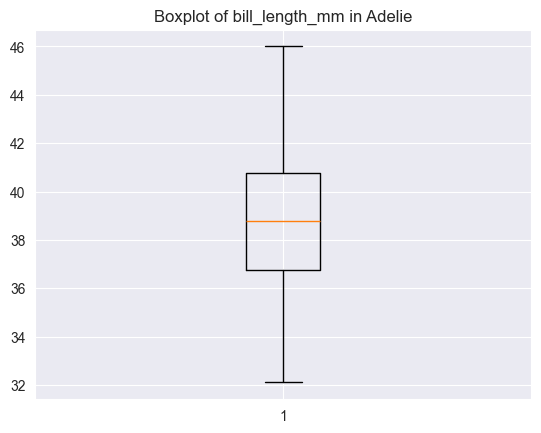

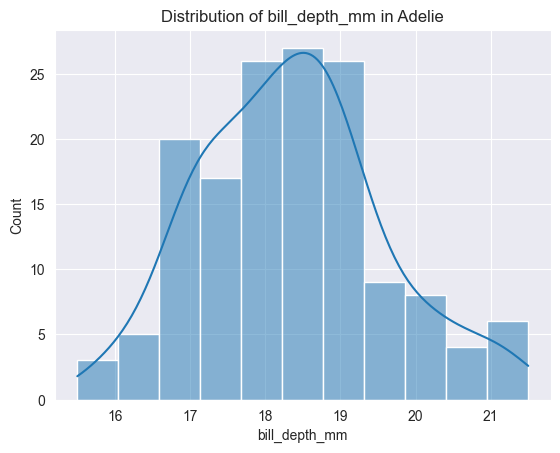

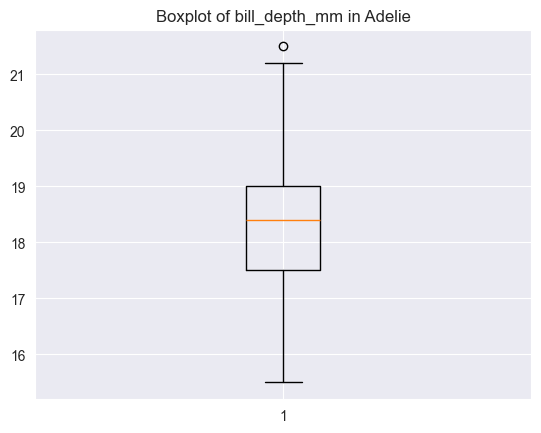

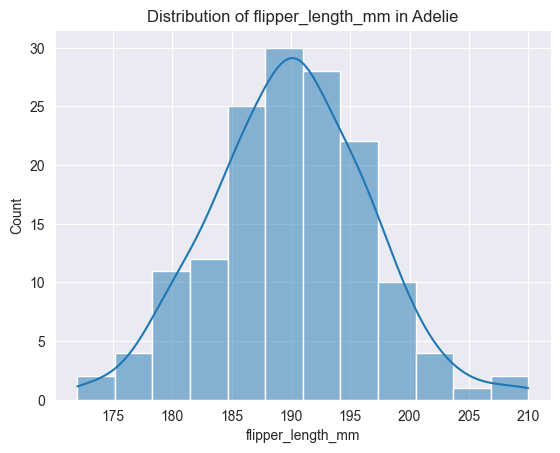

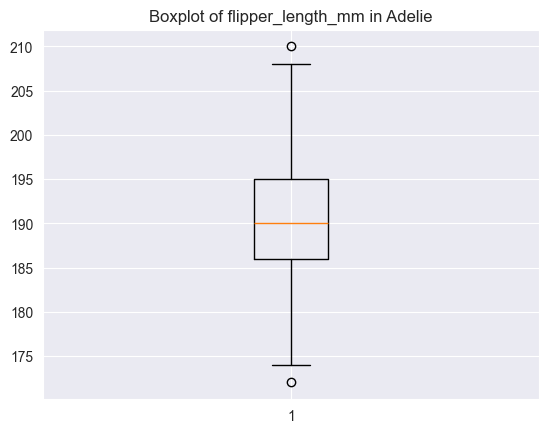

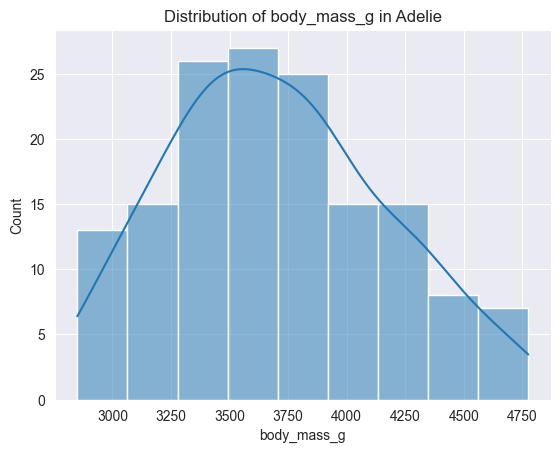

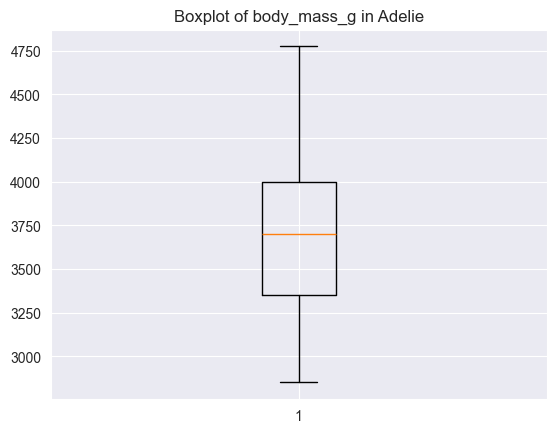

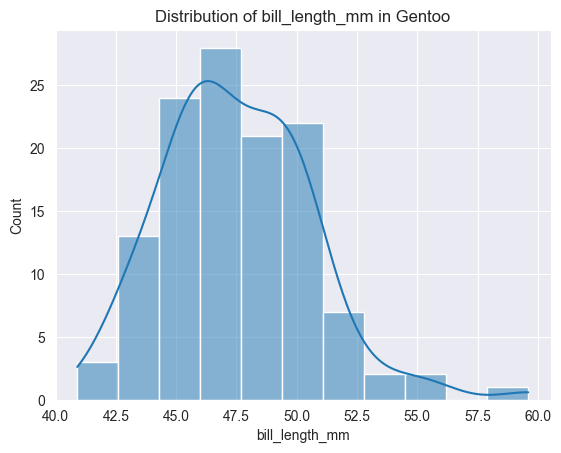

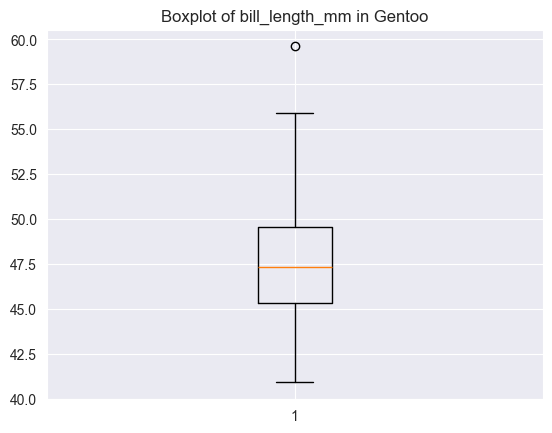

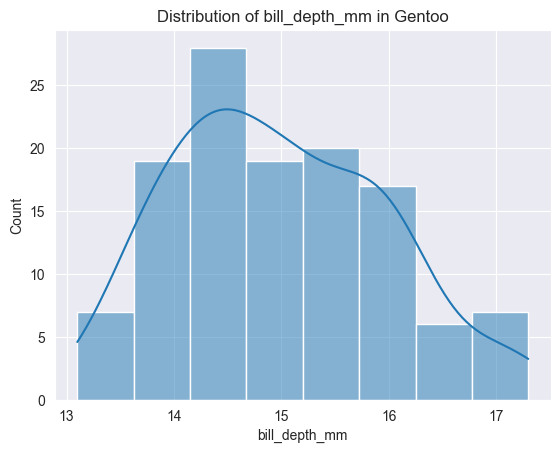

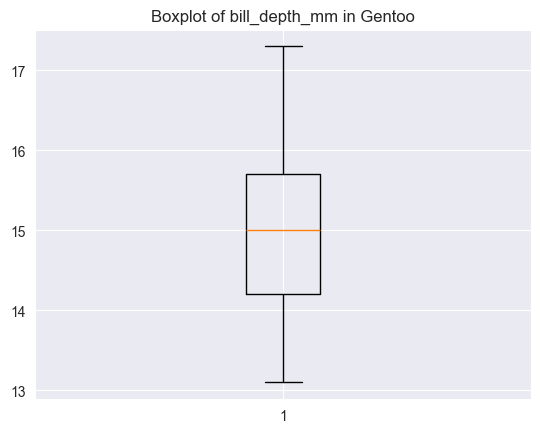

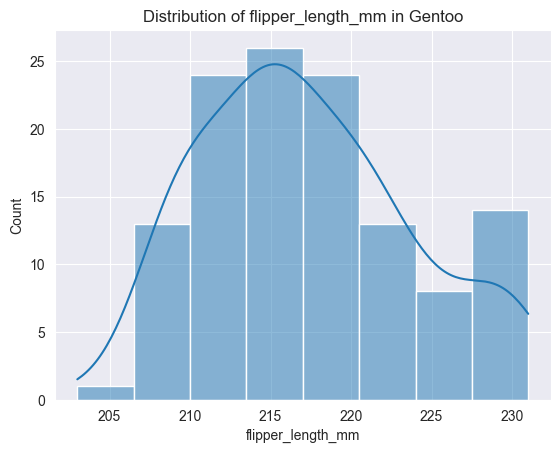

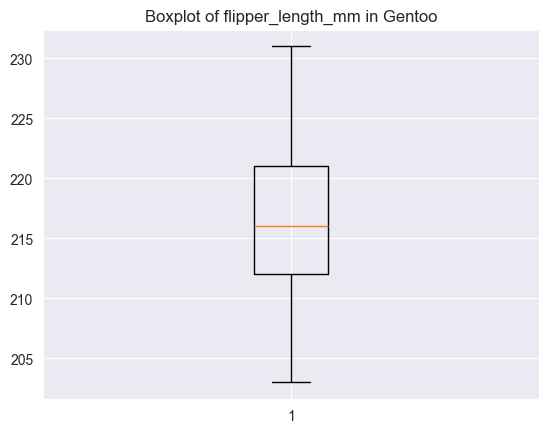

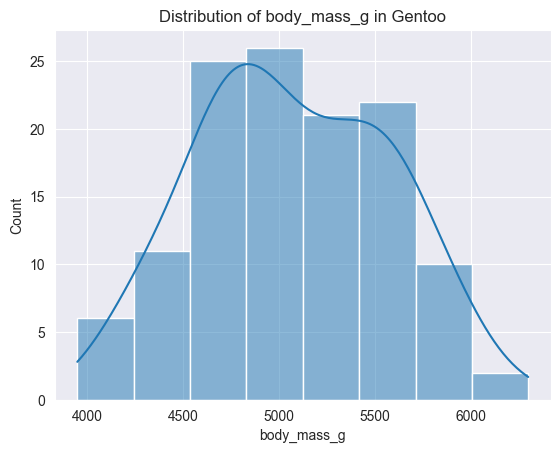

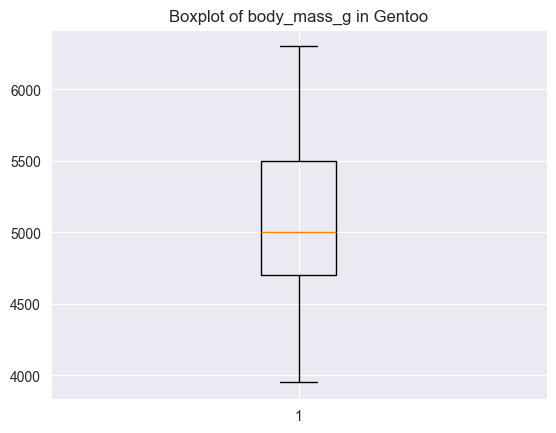

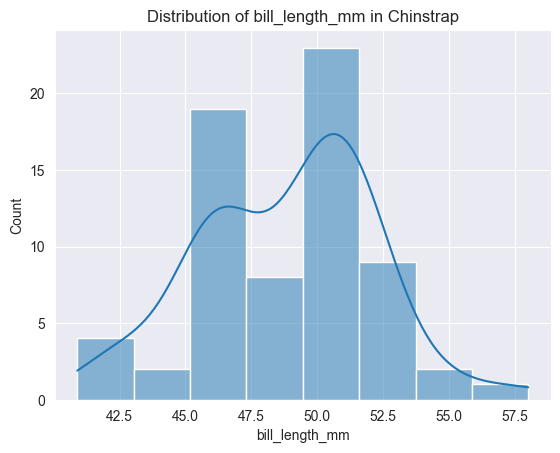

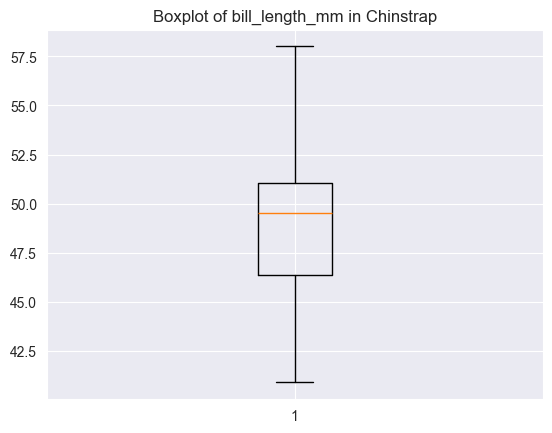

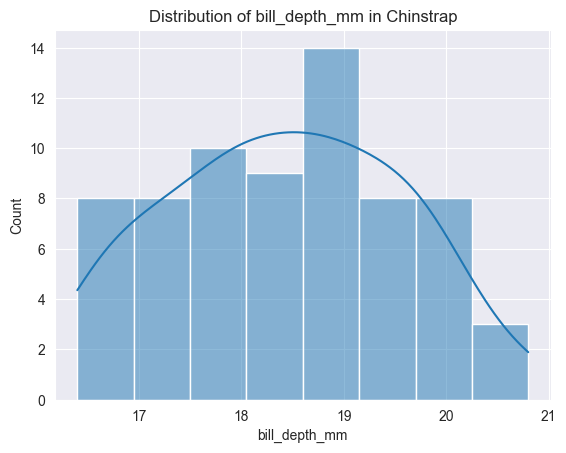

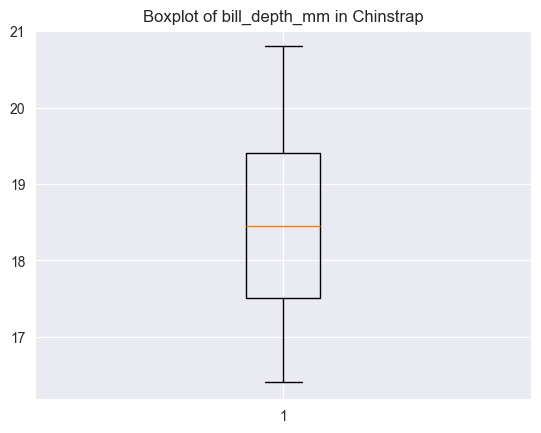

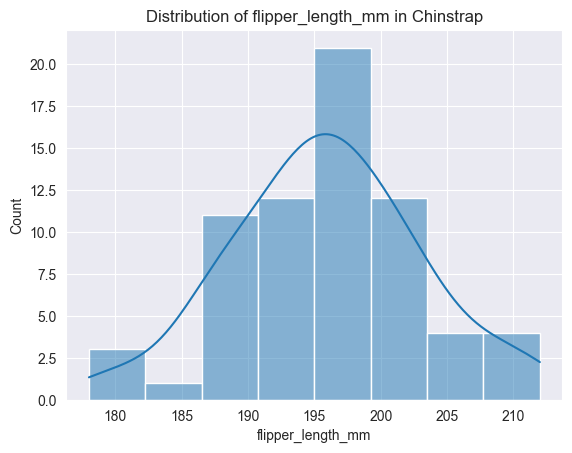

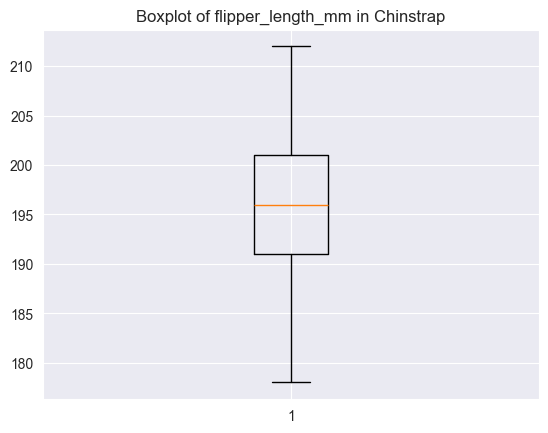

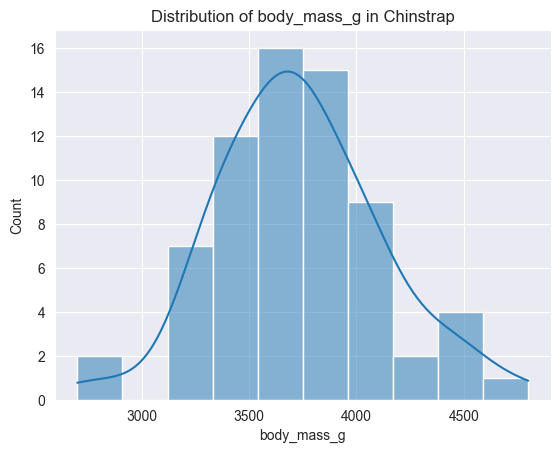

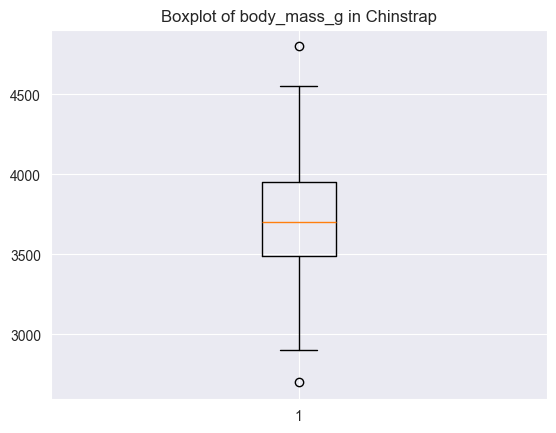

In [214]:
species_col = ['Adelie', 'Gentoo', 'Chinstrap']
for species_name in species_col:
    for column_name in numerical_cols:
        x_val = penguin_df[penguin_df['species'] == species_name][column_name]
        sns.histplot(x_val,kde=True)
        plt.title(f'Distribution of {column_name} in {species_name}')
        plt.show()
        plt.boxplot(x_val)
        plt.title(f'Boxplot of {column_name} in {species_name}')
        plt.show()

Since the bell curve is not always a good test to check normal distribution, we redo the histograms with different bin amounts, use the Shapiro-Wilkes test, and use Q and Q plots. This will give us more information about whether this information is truly normally distributed.

In [215]:
Adelie_Data = penguin_df.groupby('species').get_group('Adelie').copy()
Adelie_Data.tail()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
147,Adelie,36.6,18.4,184.0,3475.0
148,Adelie,36.0,17.8,195.0,3450.0
149,Adelie,37.8,18.1,193.0,3750.0
150,Adelie,36.0,17.1,187.0,3700.0
151,Adelie,41.5,18.5,201.0,4000.0


In [216]:
Gentoo_Data = penguin_df.groupby('species').get_group('Gentoo').copy()
Gentoo_Data.tail()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
270,Gentoo,47.2,13.7,214.0,4925.0
272,Gentoo,46.8,14.3,215.0,4850.0
273,Gentoo,50.4,15.7,222.0,5750.0
274,Gentoo,45.2,14.8,212.0,5200.0
275,Gentoo,49.9,16.1,213.0,5400.0


In [217]:
Chinstrap_Data = penguin_df.groupby('species').get_group('Chinstrap').copy()
Chinstrap_Data.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
276,Chinstrap,46.5,17.9,192.0,3500.0
277,Chinstrap,50.0,19.5,196.0,3900.0
278,Chinstrap,51.3,19.2,193.0,3650.0
279,Chinstrap,45.4,18.7,188.0,3525.0
280,Chinstrap,52.7,19.8,197.0,3725.0


In [218]:
#sturges formula for figuring out how many bins for the bell curves
for species_name in species_col:
    for column_name in numerical_cols:
        print(1 + math.log2(len(penguin_df[penguin_df['species'] == species_name][column_name])))

8.238404739325079
8.238404739325079
8.238404739325079
8.238404739325079
7.94251450533924
7.94251450533924
7.94251450533924
7.94251450533924
7.087462841250339
7.087462841250339
7.087462841250339
7.087462841250339


array([[<Axes: title={'center': 'bill_length_mm'}>,
        <Axes: title={'center': 'bill_depth_mm'}>],
       [<Axes: title={'center': 'flipper_length_mm'}>,
        <Axes: title={'center': 'body_mass_g'}>]], dtype=object)

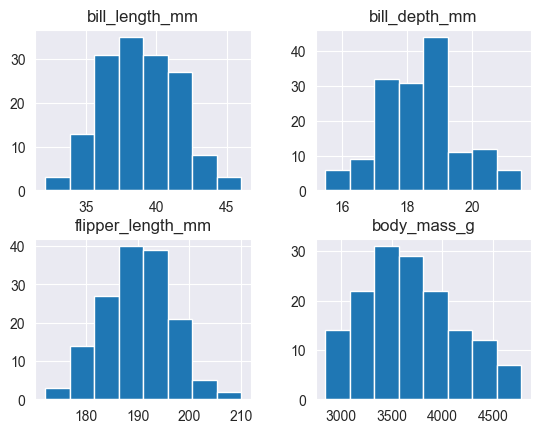

In [40]:
Adelie_Data.hist(bins=8)

array([[<Axes: title={'center': 'bill_length_mm'}>,
        <Axes: title={'center': 'bill_depth_mm'}>],
       [<Axes: title={'center': 'flipper_length_mm'}>,
        <Axes: title={'center': 'body_mass_g'}>]], dtype=object)

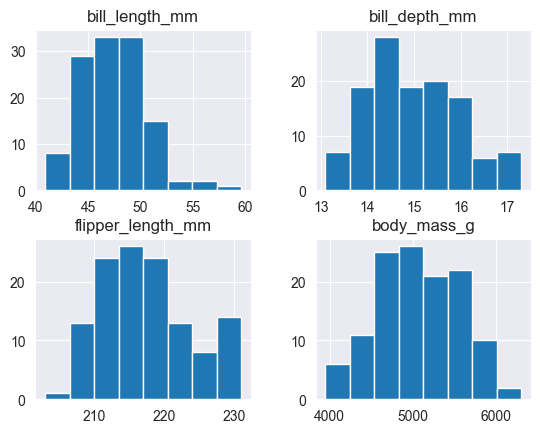

In [41]:
Gentoo_Data.hist(bins=8)

array([[<Axes: title={'center': 'bill_length_mm'}>,
        <Axes: title={'center': 'bill_depth_mm'}>],
       [<Axes: title={'center': 'flipper_length_mm'}>,
        <Axes: title={'center': 'body_mass_g'}>]], dtype=object)

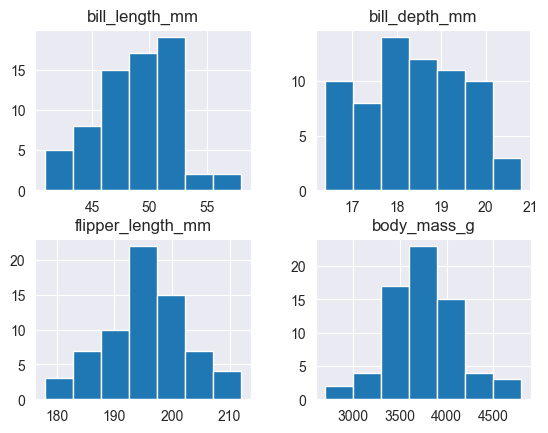

In [42]:
Chinstrap_Data.hist(bins=7)

Shapiro Wilkes Test

This is a test to check if the data is normally distributed.

Null hypothesis(H₀): The data is likely to be normally distributed. 

Alternate hypothesis(H₁): The data is not likely to be normally distributed.
We can tell if it is not normally distributed if p-val < 0.05.

We can also use Q and Q plots, which show a normal distribution through a 45 degree line. If the plots mostly match this line, the data is most likely to be normally distributed.

Adelie Data:
According to the Shapiro-Wilkes test, bill length, bill depth, and flipper length are likely to be normally distributed. 
According to the Q and Q plots, all of the graphs except body_mass_g seem to be normally distributed or almost normally distributed. 

In [172]:
for column_name in numerical_cols:
       print(f'{column_name}: {stats.shapiro(Adelie_Data[column_name])}')

bill_length_mm: ShapiroResult(statistic=np.float64(0.9933617523796489), pvalue=np.float64(0.7166005498799634))
bill_depth_mm: ShapiroResult(statistic=np.float64(0.9846683186454743), pvalue=np.float64(0.09248966375050499))
flipper_length_mm: ShapiroResult(statistic=np.float64(0.9933915645236039), pvalue=np.float64(0.7200466209971224))
body_mass_g: ShapiroResult(statistic=np.float64(0.9807078507062791), pvalue=np.float64(0.03239702501305107))


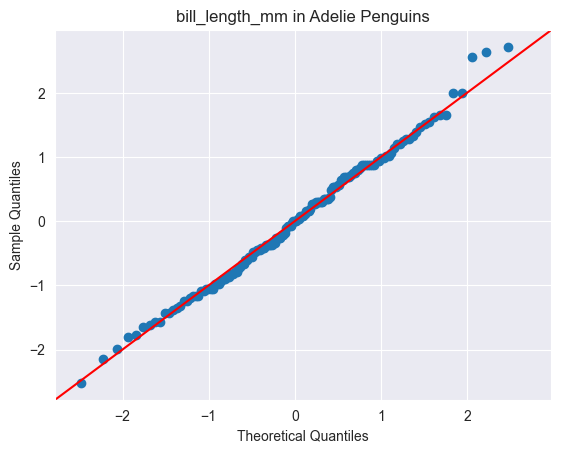

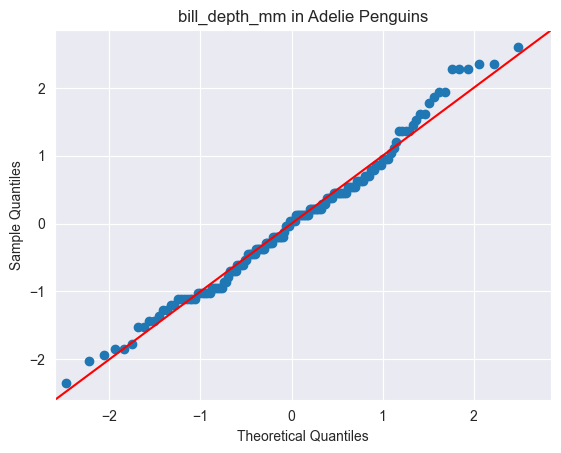

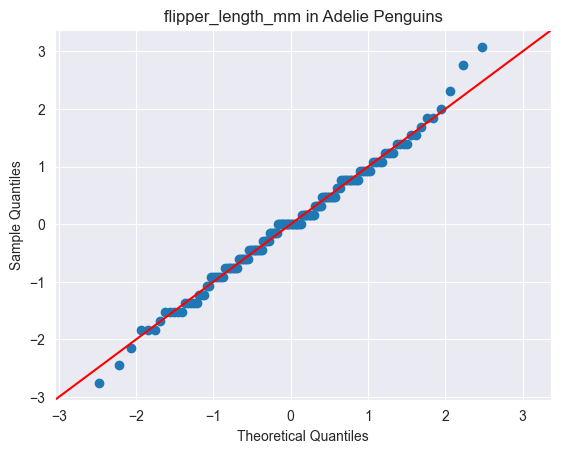

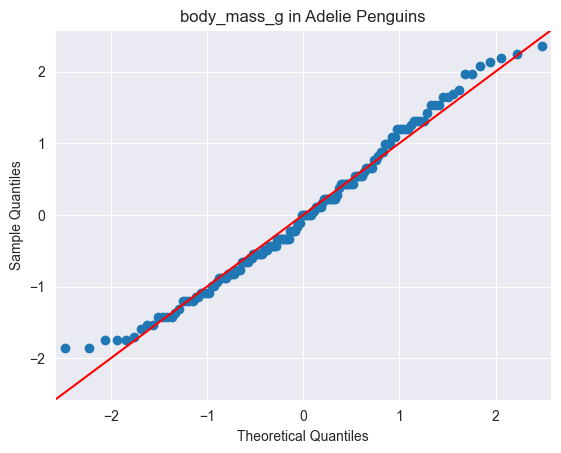

In [231]:
for column_name in numerical_cols:
    sm.qqplot(Adelie_Data[column_name], line='45', fit=True)
    plt.title(f'{column_name} in Adelie Penguins')
    plt.show()

Gentoo Data:
According to the Shapiro-Wilkes test, only body_mass_g is likely to be normally distributed. 
According to the Q and Q plots, bill depth and body mass are normally distributed or almost normally distributed. 

In [174]:
for column_name in numerical_cols:
       print(f'{column_name}: {stats.shapiro(Gentoo_Data[column_name])}')

bill_length_mm: ShapiroResult(statistic=np.float64(0.9727224329747974), pvalue=np.float64(0.013491432169875316))
bill_depth_mm: ShapiroResult(statistic=np.float64(0.9760938151146827), pvalue=np.float64(0.02769509478233595))
flipper_length_mm: ShapiroResult(statistic=np.float64(0.9621935760616585), pvalue=np.float64(0.001619814121000909))
body_mass_g: ShapiroResult(statistic=np.float64(0.9859276066609362), pvalue=np.float64(0.23361648888961845))


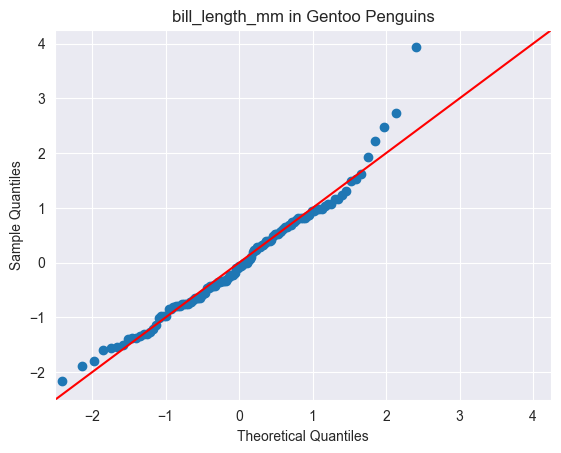

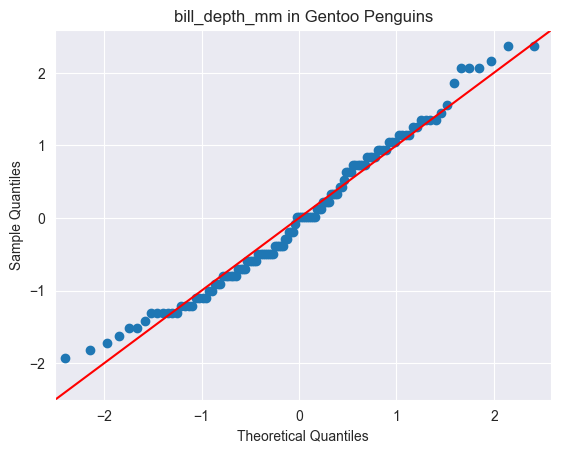

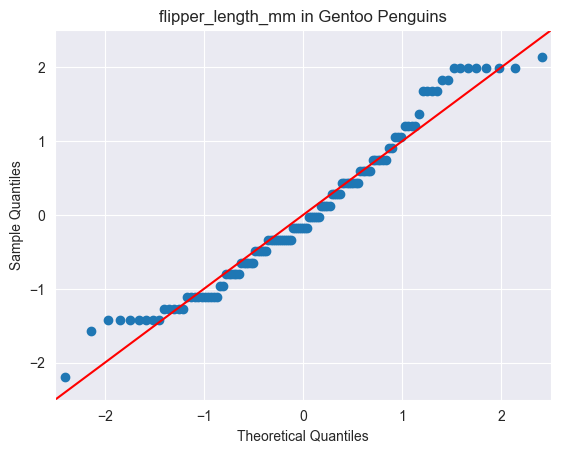

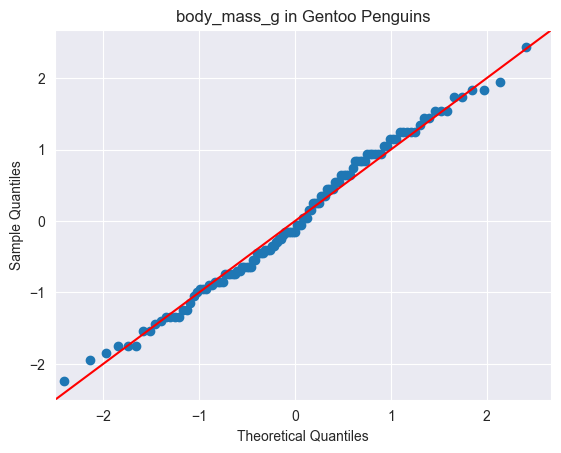

In [232]:
for column_name in numerical_cols:
    sm.qqplot(Gentoo_Data[column_name], line='45', fit=True)
    plt.title(f'{column_name} in Gentoo Penguins')
    plt.show()

Chinstrap Data:
According to the Shapiro-Wilkes test, all values are normally distributed. 
According to the Q and Q plots, bill depth, flipper length, and body mass are normally distributed or almost normally distributed. 

In [176]:
for column_name in numerical_cols:
       print(f'{column_name}: {stats.shapiro(Chinstrap_Data[column_name])}')

bill_length_mm: ShapiroResult(statistic=np.float64(0.9752496075500775), pvalue=np.float64(0.1940925740620773))
bill_depth_mm: ShapiroResult(statistic=np.float64(0.9727431838425551), pvalue=np.float64(0.14178462574530526))
flipper_length_mm: ShapiroResult(statistic=np.float64(0.9889114828625576), pvalue=np.float64(0.8106446568669051))
body_mass_g: ShapiroResult(statistic=np.float64(0.984493761674102), pvalue=np.float64(0.5605082387697975))


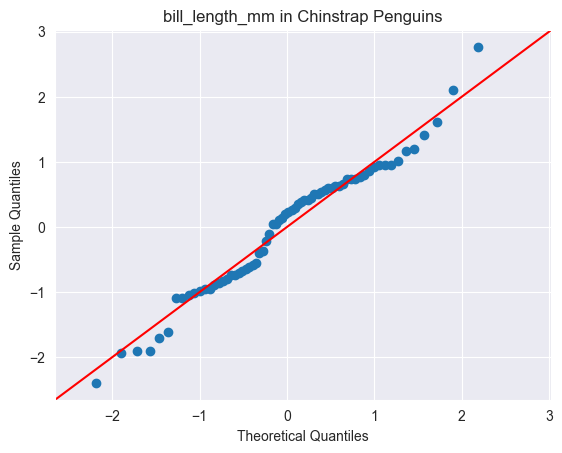

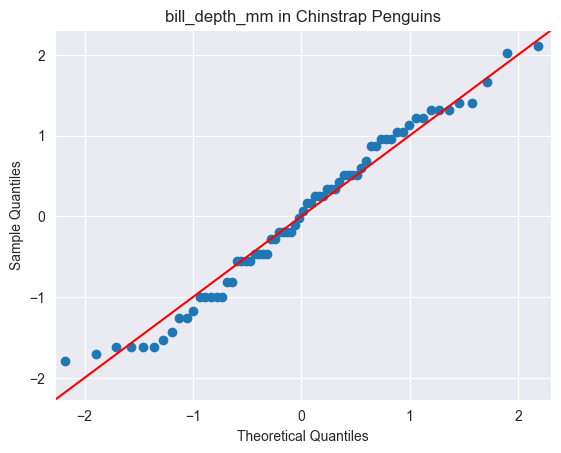

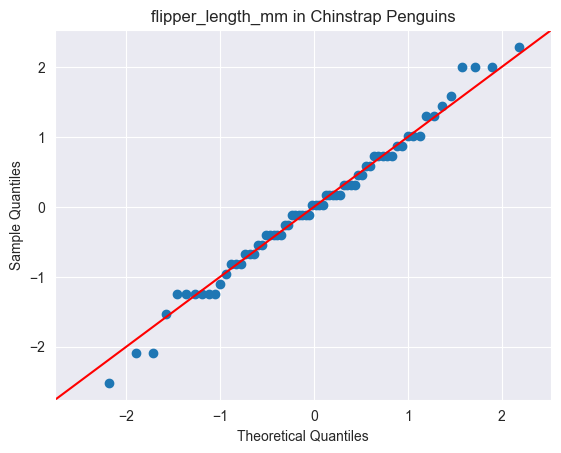

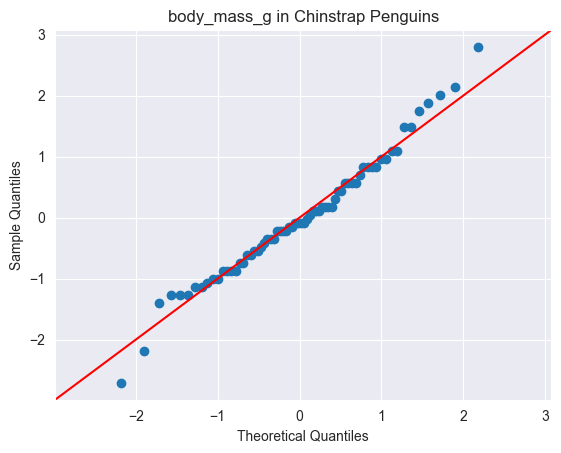

In [233]:
for column_name in numerical_cols:
    sm.qqplot(Chinstrap_Data[column_name], line='45', fit=True)
    plt.title(f'{column_name} in Chinstrap Penguins')
    plt.show()

### T And Anova Test
Based on the previous information, we will move ahead with bill_depth_mm as it seems to have two data columns with normally distributed data and one data column with almost normally distributed data. 

In order to continue, we need to check that bill_depth_mm has similar variances by using the Levene Test and ensuring we get a high p-value. The p-value should be higher than the average p-value (0.05).

Null hypothesis(H₀): The data is likely to have similar variances between groups.

Alternate hypothesis(H₁): At least one data group is likely to not have similar variances.

Since all variances below have a p-value greater than 0.05, we can say that they have similar variances, and continue with our T-tests and Anova tests. 
Since p-val>0.05, we fail to reject the alternate hypothesis and can say that the data is likely to have similar variances.

Side Note: These values are all independent, as they include different species of penguins and different individuals, so we can use these tests.

In [234]:
stats.levene(Adelie_Data['bill_depth_mm'], Chinstrap_Data['bill_depth_mm'])

LeveneResult(statistic=np.float64(0.008216885456270195), pvalue=np.float64(0.927856671249176))

In [45]:
stats.levene(Gentoo_Data['bill_depth_mm'], Chinstrap_Data['bill_depth_mm'])

LeveneResult(statistic=np.float64(2.709827985529575), pvalue=np.float64(0.1013935999372208))

In [46]:
stats.levene(Gentoo_Data['bill_depth_mm'], Adelie_Data['bill_depth_mm'])

LeveneResult(statistic=np.float64(3.5213092858919346), pvalue=np.float64(0.06165516482894236))

In [47]:
stats.levene(Adelie_Data['bill_depth_mm'], Gentoo_Data['bill_depth_mm'], Chinstrap_Data['bill_depth_mm'])

LeveneResult(statistic=np.float64(2.036938873955207), pvalue=np.float64(0.1320206720214083))

The following data is normally distributed, so we are going to use a T-test to analyze the means.

Null hypothesis(H₀): The mean is the same between the two groups.

Alternate hypothesis(H₁): The mean is not the same between the two groups.

Since the p-value is greater than 0.05, we fail to reject the null hypothesis. Therefore, it is likely that the mean of bill depths is the same between the two groups.

In [48]:
stats.ttest_ind(Adelie_Data['bill_depth_mm'], Chinstrap_Data['bill_depth_mm'])

TtestResult(statistic=np.float64(-0.4263555696052772), pvalue=np.float64(0.670271404572417), df=np.float64(217.0))

The following data is mostly normally distributed, so we are going to use an ANOVA to analyze the means.

Null hypothesis(H₀): The mean is the same between the groups.

Alternate hypothesis(H₁): The mean is not the same between at least two of the groups.

Since the p-value is less than 0.05, we reject the null hypothesis. We can conclude that it is likely that at least two groups do not have the same mean for the bill depth.
Since one group is only partially normally distributed, it increases the likelihood of a Type 1 Error. Thus, we will rely on the following test.

In [49]:
stats.f_oneway(Adelie_Data['bill_depth_mm'],Gentoo_Data['bill_depth_mm'],Chinstrap_Data['bill_depth_mm'])

F_onewayResult(statistic=np.float64(359.7891488231531), pvalue=np.float64(1.5076575342210204e-84))

Since the p-value from the ANOVA test seems a little extreme, we will try a different ANOVA test that is not sensitive to data that is not normally distributed. This is called the Kruskal-Wallis Test.

Null hypothesis(H₀): The median is the same between the groups.

Alternate hypothesis(H₁): The median is not the same between at least two of the groups.

Since the p-value is less than 0.05, we reject the null hypothesis. We can conclude that it is likely that at least two groups do not have the same median for their bill depths.

Based on the two test, we have evidence that bill_depth_mm in at least two groups is statistically different and significant. We can at least conclude that they have differences in their median.

In [50]:
stats.kruskal(Adelie_Data['bill_depth_mm'],Gentoo_Data['bill_depth_mm'],Chinstrap_Data['bill_depth_mm'])

KruskalResult(statistic=np.float64(224.56314747994284), pvalue=np.float64(1.724773636640871e-49))

We will also perform an additional test in which we will change the skew of our data to make our data more normally distributed. Since they will be more normally distributed and they will have unequal variances, we will use Welch’s ANOVA. Welch's ANOVA allows us to use data that has unequal variances.

We first double-check that they are normally distributed. Since their p-value is greater than 0.05, we have evidence that it is normally distributed. Also, based on the bell curves, we can tell that both graphs are right skew, so the following transformations should employ a more normal distribution.

Afterward, we use the bartlett result to check if the variances are unequal amongst the normally distributed data groups. 

Null hypothesis(H₀): The data is likely to have similar variances between groups.

Alternate hypothesis(H₁): At least one data group is likely to not have similar variances.

Since both p-values are below 0.05, we can reject the null hypothesis and we can say that all at least one group does not have similar variances in their bill depth and body mass.



In [56]:
#transofromation to make the data normal (will change homogenity of variances)
transformed_Adelie = pd.DataFrame(np.sqrt(Adelie_Data['body_mass_g']), columns= ['body_mass_g'])
print(f'{stats.shapiro(transformed_Adelie['body_mass_g'])}')

transformed_Gentoo = pd.DataFrame(np.log(Gentoo_Data['bill_depth_mm']), columns= ['bill_depth_mm'])
print(f'{stats.shapiro(transformed_Gentoo['bill_depth_mm'])}')

ShapiroResult(statistic=np.float64(0.9847313873944346), pvalue=np.float64(0.09404838130072804))
ShapiroResult(statistic=np.float64(0.9808126176165732), pvalue=np.float64(0.07743768776392443))


In [57]:
print(stats.bartlett(Adelie_Data['bill_depth_mm'],transformed_Gentoo['bill_depth_mm'],Chinstrap_Data['bill_depth_mm']))
print(stats.bartlett(transformed_Adelie['body_mass_g'],Gentoo_Data['body_mass_g'],Chinstrap_Data['body_mass_g']))

BartlettResult(statistic=np.float64(556.8589544319204), pvalue=np.float64(1.2011975726082316e-121))
BartlettResult(statistic=np.float64(1248.1470363561466), pvalue=np.float64(9.296398957533838e-272))


Welch ANOVA

Null hypothesis(H₀): The mean is the same between the groups.

Alternate hypothesis(H₁): The mean is not the same between at least two of the groups.

Since both values p-values are less than 0.05, we can reject the null hypothesis, and claim that the mean in the bill depth and body mass is not the same between at least two of the groups.

In [58]:
welch_dv = pd.DataFrame({
    'bill_group': (list(Adelie_Data['bill_depth_mm'])+list(transformed_Gentoo['bill_depth_mm'])+list(Chinstrap_Data['bill_depth_mm'])),
    'group_names': 
        (['Adelie']*len(Adelie_Data['bill_depth_mm']))+
       (['Gentoo']*len(Gentoo_Data['bill_depth_mm']))+
       (['Chinstrap']*len(Chinstrap_Data['bill_depth_mm']))
})
pg.welch_anova(data = welch_dv, between= 'group_names', dv='bill_group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group_names,2,124.077634,18791.546997,9.426270e-155,0.984268


In [59]:
welch_dv = pd.DataFrame({
    'body_group': (list(transformed_Adelie['body_mass_g'])+list(Gentoo_Data['body_mass_g'])+list(Chinstrap_Data['body_mass_g'])),
    'group_names': 
        (['Adelie']*len(Adelie_Data['bill_depth_mm']))+
       (['Gentoo']*len(Gentoo_Data['bill_depth_mm']))+
       (['Chinstrap']*len(Chinstrap_Data['bill_depth_mm']))
})
pg.welch_anova(data = welch_dv, between= 'group_names', dv='body_group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group_names,2,115.339903,9137.663715,9.443490e-128,0.977961


Since we are checking growth in three species of penguin, the above data makes sense as these species have incredibly different variations. 

### Linear Regression

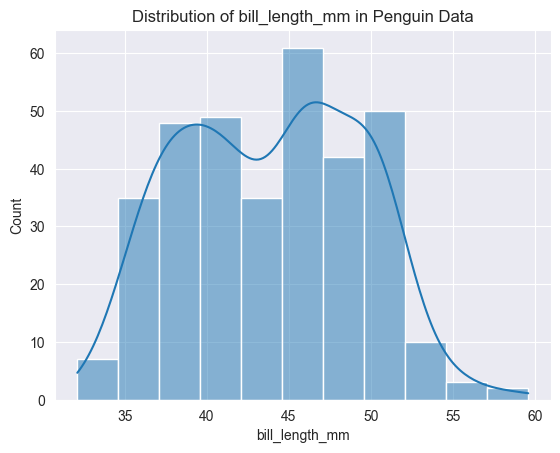

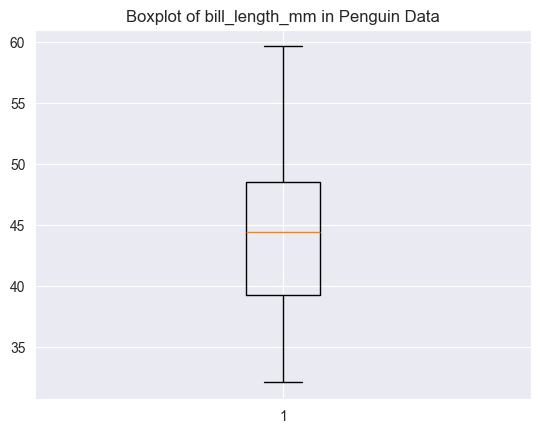

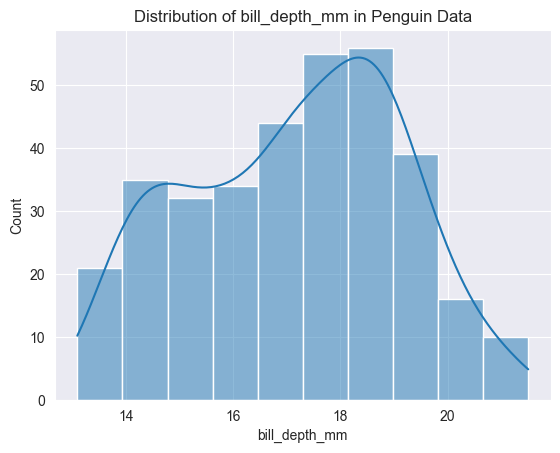

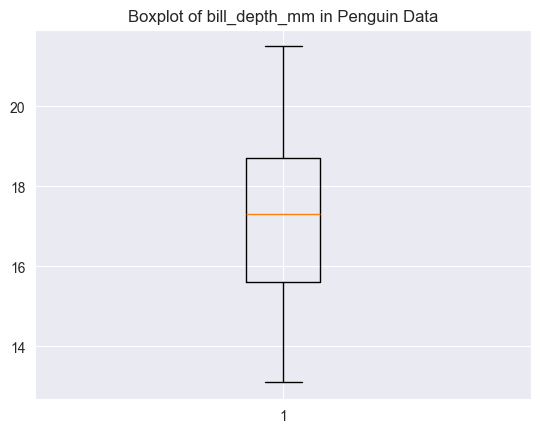

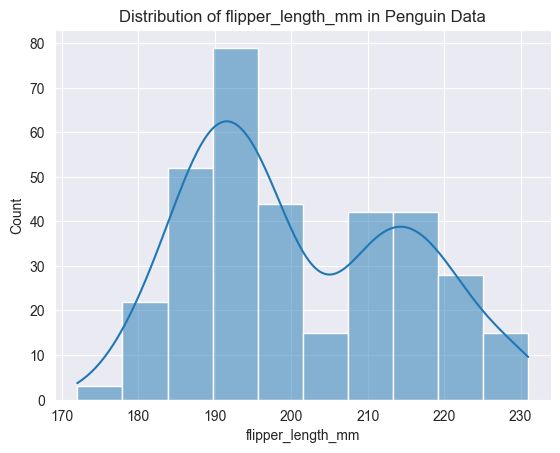

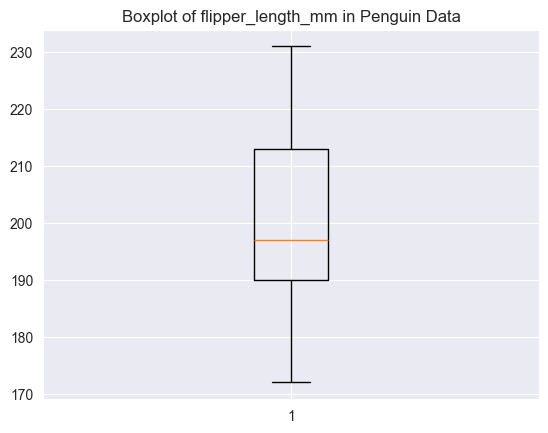

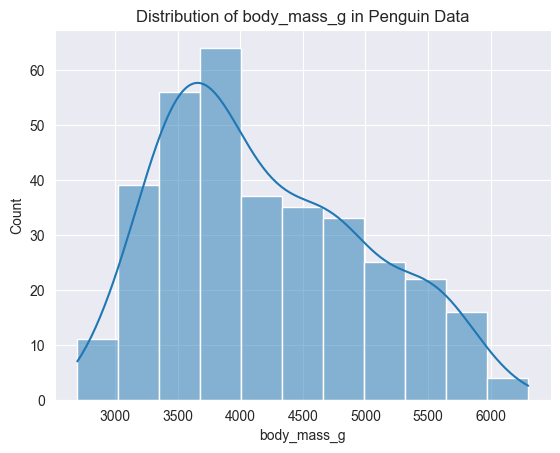

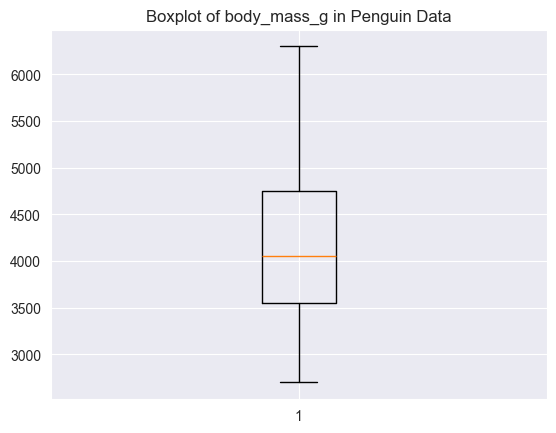

In [235]:
for column_name in numerical_cols:
        x_val = penguin_df[column_name]
        sns.histplot(x_val,kde=True)
        plt.title(f'Distribution of {column_name} in Penguin Data')
        plt.show()
        plt.boxplot(x_val)
        plt.title(f'Boxplot of {column_name} in Penguin Data')
        plt.show()

In [236]:
penguin_corr = penguin_df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr()
print(penguin_corr)

                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm           1.000000      -0.235053           0.656181   
bill_depth_mm           -0.235053       1.000000          -0.583851   
flipper_length_mm        0.656181      -0.583851           1.000000   
body_mass_g              0.595110      -0.471916           0.871202   

                   body_mass_g  
bill_length_mm        0.595110  
bill_depth_mm        -0.471916  
flipper_length_mm     0.871202  
body_mass_g           1.000000  


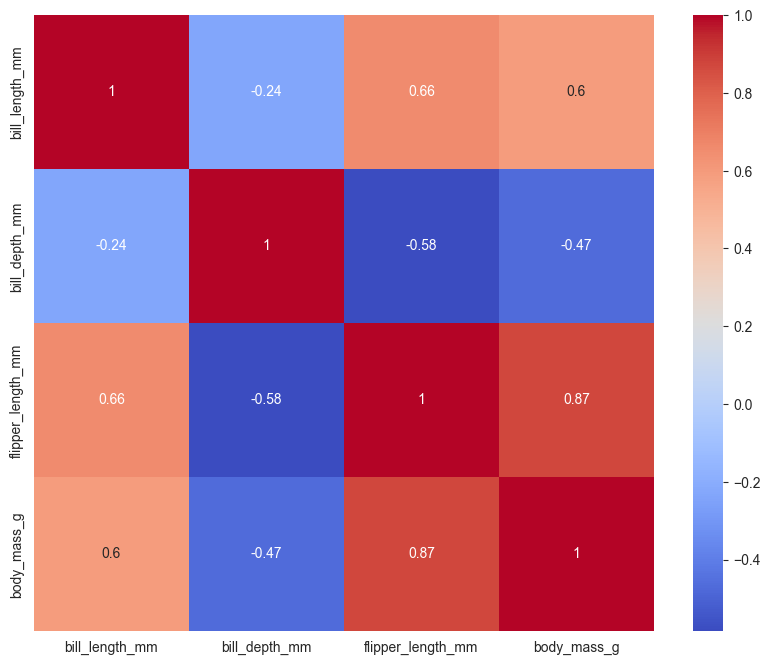

In [237]:
plt.figure(figsize = (10,8))
sns.heatmap(penguin_corr, annot=True, cmap='coolwarm')
plt.show()

In [264]:
pipeline = make_pipeline(QuantileTransformer(output_distribution='uniform', n_quantiles=50),
                         PCA(n_components=3),
                         StandardScaler(),
                         LinearRegression())

x = penguin_df.drop(['flipper_length_mm', 'species'], axis=1)
y = penguin_df['flipper_length_mm']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

pipeline.fit(X_train,Y_train)
print(f"Model score: {pipeline.score(X_train, Y_train)*100}%")

Model score: 83.82405564734269%


These numbers symbolize that the model is good at determining new predictions. Since the range in predictions is very small, it is good that we receive a mae and rmse that is less than 6. If there were a higher range, then a MAE and RMSE less than 10 would be good.

In [263]:
Y_pred = pipeline.predict(X_test)
print(f'MAE: {mean_absolute_error(Y_test, Y_pred)}')
print(f'RMSE: {root_mean_squared_error(Y_test, Y_pred)}')
print(f'R2 Score: {r2_score(Y_test, Y_pred)}')

MAE: 4.212540085963551
RMSE: 5.291991428280031
R2 Score: 0.839726712603141
